# GSM8K pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results`, then plot how RL fine-tuning moves performance from its starting checkpoint.



In [1]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root location for evaluation outputs and the metric key to read
BASE_DIR = Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results")
DATASET_KEY = "test_score/openai/gsm8k"

print(f"Base directory: {BASE_DIR}")



Base directory: /n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results


In [7]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    - For majority files (samples > 1 or filename contains 'majority'), look for a line
      containing 'Pass@' and take the first float after the colon.
    - Otherwise, look for the last dict line containing the dataset_key.
    """
    if not result_path.exists():
        return None

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        for line in text:
            if "Pass@" in line:
                # Expect formats like: "Pass@32 (Any Correct):            0.6884 (68.84%)"
                parts = line.split(":")
                if len(parts) > 1:
                    try:
                        return float(parts[1].split()[0])
                    except Exception:
                        pass
                # Fallback: grab first float on the line
                import re as _re
                match = _re.search(r"([0-9]*\.?[0-9]+)", line)
                if match:
                    try:
                        return float(match.group(1))
                    except Exception:
                        pass
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return payload[dataset_key]
    return None

# Collect pre-train runs (pattern: 1B-step{step}-{shot}shot-{samples}samples-temp{temp})
pretrain_rows = []
pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# Collect RL runs from both naming schemes below
#   1) 1B-step{pt_step}-rl-step{rl_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) olmo2_1b_step{pt_step}_omigsm8k-step{rl_step}-rl-0shot-boxed-{samples}samples-temp{temp}
rl_rows = []
rl_patterns = [
    re.compile(r"1B-step(?P<pt_step>\d+)-rl-step(?P<rl_step>\d+)-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
]

for path in BASE_DIR.iterdir():
    if not path.is_dir():
        continue
    name = path.name

    # Pre-train collection
    pre_match = pre_pattern.match(name)
    if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
        samples = int(pre_match.group("samples"))
        result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
        score = read_score(path / result_file, samples=samples)
        pretrain_rows.append(
            {
                "step": int(pre_match.group("step")),
                "shot": int(pre_match.group("shot")),
                "samples": samples,
                "temp": float(pre_match.group("temp")),
                "score": score,
                "path": str(path),
            }
        )
        continue

    # RL collection (first pattern that matches wins)
    for pat in rl_patterns:
        rl_match = pat.match(name)
        if rl_match:
            samples = int(rl_match.group("samples"))
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            score = read_score(path / result_file, samples=samples)
            pt_step = int(rl_match.group("pt_step"))
            rl_step = int(rl_match.group("rl_step"))
            rl_rows.append(
                {
                    "pt_step": pt_step,
                    "rl_step": rl_step,
                    "total_step": pt_step + rl_step,
                    "samples": samples,
                    "temp": float(rl_match.group("temp")),
                    "score": score,
                    "path": str(path),
                    "label": name,
                }
            )
            break

pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)

print(f"Loaded {len(pre_df)} pre-train runs and {len(rl_df)} RL runs.")



Loaded 85 pre-train runs and 32 RL runs.


In [8]:
pre_df.sort_values(["step", "shot", "samples", "temp"])

,step,shot,samples,temp,score,path
0,1000,1,1,0.0,0.023503,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,1,8,0.6,0.035600,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
1,1000,1,32,0.6,0.059100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
4,1000,8,1,0.0,0.015921,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
7,1000,8,8,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
46,22000,8,8,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
47,22000,8,8,0.6,0.462500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
44,22000,8,32,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
45,22000,8,32,0.6,0.688400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


In [9]:
display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
print()
display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp"]))



,step,shot,samples,temp,score,path
0,1000,1,1,0.0,0.023503,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,1,8,0.6,0.035600,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
1,1000,1,32,0.6,0.059100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
4,1000,8,1,0.0,0.015921,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
7,1000,8,8,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
46,22000,8,8,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
47,22000,8,8,0.6,0.462500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
44,22000,8,32,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
45,22000,8,32,0.6,0.688400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,score,path,label
5,5000,650,5650,1,0.0,0.062168,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,1B-step5000-rl-step650-0shot-boxed-1samples-te...
21,5000,800,5800,1,0.0,0.063685,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step5000_omigsm8k-step800-rl-0shot-bo...
23,5000,800,5800,8,0.6,0.091000,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step5000_omigsm8k-step800-rl-0shot-bo...
22,5000,800,5800,32,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step5000_omigsm8k-step800-rl-0shot-bo...
20,5000,800,5800,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step5000_omigsm8k-step800-rl-0shot-bo...
6,6000,650,6650,1,0.0,0.056861,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,1B-step6000-rl-step650-0shot-boxed-1samples-te...
25,6000,800,6800,1,0.0,0.056103,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step6000_omigsm8k-step800-rl-0shot-bo...
27,6000,800,6800,8,0.6,0.096300,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step6000_omigsm8k-step800-rl-0shot-bo...
26,6000,800,6800,32,0.6,0.116800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step6000_omigsm8k-step800-rl-0shot-bo...
24,6000,800,6800,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step6000_omigsm8k-step800-rl-0shot-bo...


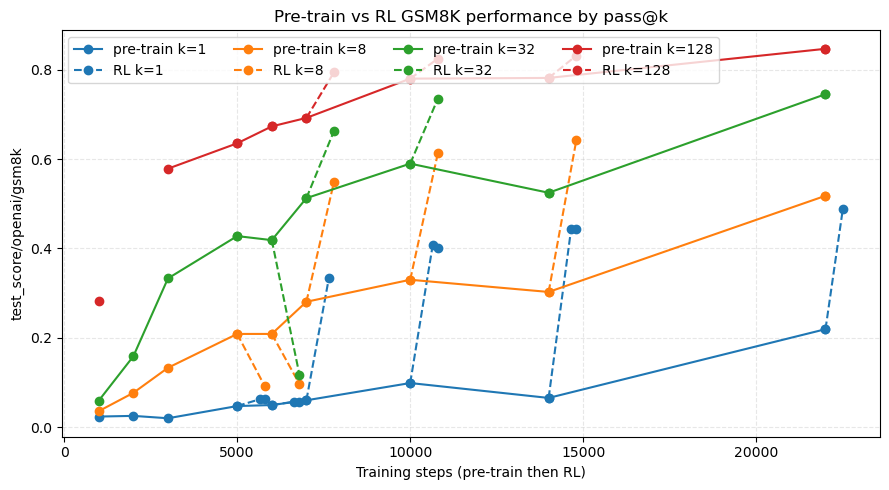

In [14]:
# Plot multiple pass@k curves (samples) on the same axes
PLOT_SAMPLES = [1, 8, 32, 128]  # edit as needed
PRETRAIN_SHOT = 1
TEMP_BY_SAMPLES = lambda s: 0.0 if s == 1 else 0.6  # adjust if other temps used

available_samples = sorted(set(pre_df["samples"].tolist()) | set(rl_df["samples"].tolist()))
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

fig, ax = plt.subplots(figsize=(9, 5))
cmap = plt.get_cmap("tab10")
added_labels = set()

if not plot_samples:
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
else:
    for idx, samples in enumerate(plot_samples):
        target_temp = TEMP_BY_SAMPLES(samples)
        color = cmap(idx % 10)

        if samples == 128:
            PRETRAIN_SHOT = 8
        else:
            PRETRAIN_SHOT = 1
        pre_curve = (
            pre_df[
                (pre_df["samples"] == samples)
                & (pre_df["shot"] == PRETRAIN_SHOT)
                & (pre_df["temp"] == target_temp)
            ]
            .sort_values("step")
        )
        if not pre_curve.empty:
            ax.plot(
                pre_curve["step"],
                pre_curve["score"],
                marker="o",
                color=color,
                label=f"pre-train k={samples}",
            )

        rl_curve = (
            rl_df[(rl_df["samples"] == samples) & (rl_df["temp"] == target_temp)]
            .sort_values(["pt_step", "rl_step"])
        )
        # Group RL results by starting pre-train step so multiple rl_step values become one curve
        for pt_step, group in rl_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None

            group_sorted = group.sort_values("rl_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
            ys.extend(group_sorted["score"].tolist())

            # label = f"RL from {pt_step} k={samples}"
            label = f"RL k={samples}"
            label_out = label if label not in added_labels else None

            if not xs:
                continue
            ax.plot(
                xs,
                ys,
                linestyle="--",
                marker="o",
                color=color,
                label=label_out,
            )
            added_labels.add(label)

ax.set_xlabel("Training steps (pre-train then RL)")
ax.set_ylabel(DATASET_KEY)
ax.set_title("Pre-train vs RL GSM8K performance by pass@k")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(ncol=4)
plt.tight_layout()
plt.show()